In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')

from pipeline import create_dataset

%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/labeled_ttv/')
unlab_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/unlabeled_ttv/')
model_name = "teacher1"

conf = {
    # Dataset
    "data_dir": data_dir,
    "unlab_dir": unlab_dir,
    "log_dir": "./",
    "cache_dir": "./cache",
    "ds_info": 'hypkva',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0.1,
    "resample": False,
    "class_weight": False,
    "shuffle_buffer_size": 0,        # 0=no shuffling
    "seed": 2511,
    "neg_class": None,                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model_name": model_name,
    "model": 'EfficientNetB0',
    "dropout": 0.1,
    "num_epochs": 25,
    "batch_size": 128,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',     # sigmoid for binary ds
    # Callbacks
    "learning_schedule": True,
    "decay_rate": 0.1,                 # higher number gives steeper lr dropoff
    "checkpoint": False,
    "early_stopp": True,
    "early_stopp_patience": 8,
    # Misc
    "verbosity": 0
    }

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [13]:
ds = create_dataset(conf)

class_names = conf["class_names"]

In [127]:
def checkout_dataset(ds):
    """
    ds is assumed to be from prepare_for_training - so batched, repeated etc
    """
    # Show some images from training dataset (mainly to check augmentation)
    batch = next(iter(ds))
    images, labels = batch
    images = images.numpy()
    labels = labels.numpy()

    nrows, ncols = 3, 4  # array of sub-plots
    figsize = [ncols*4, nrows*4]     # figure size, inches

    # create figure (fig), and array of axes (ax)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=figsize, frameon=False, facecolor='white')

    # plot simple raster image on each sub-plot
    for i, axi in enumerate(ax.flat):
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        img = images[i]
        axi.imshow(img)
        axi.set_axis_off()

    plt.axis('off')
    plt.tight_layout(True)
    plt.savefig("image_augmentations-nocrop.pdf", format='pdf')
    plt.show()

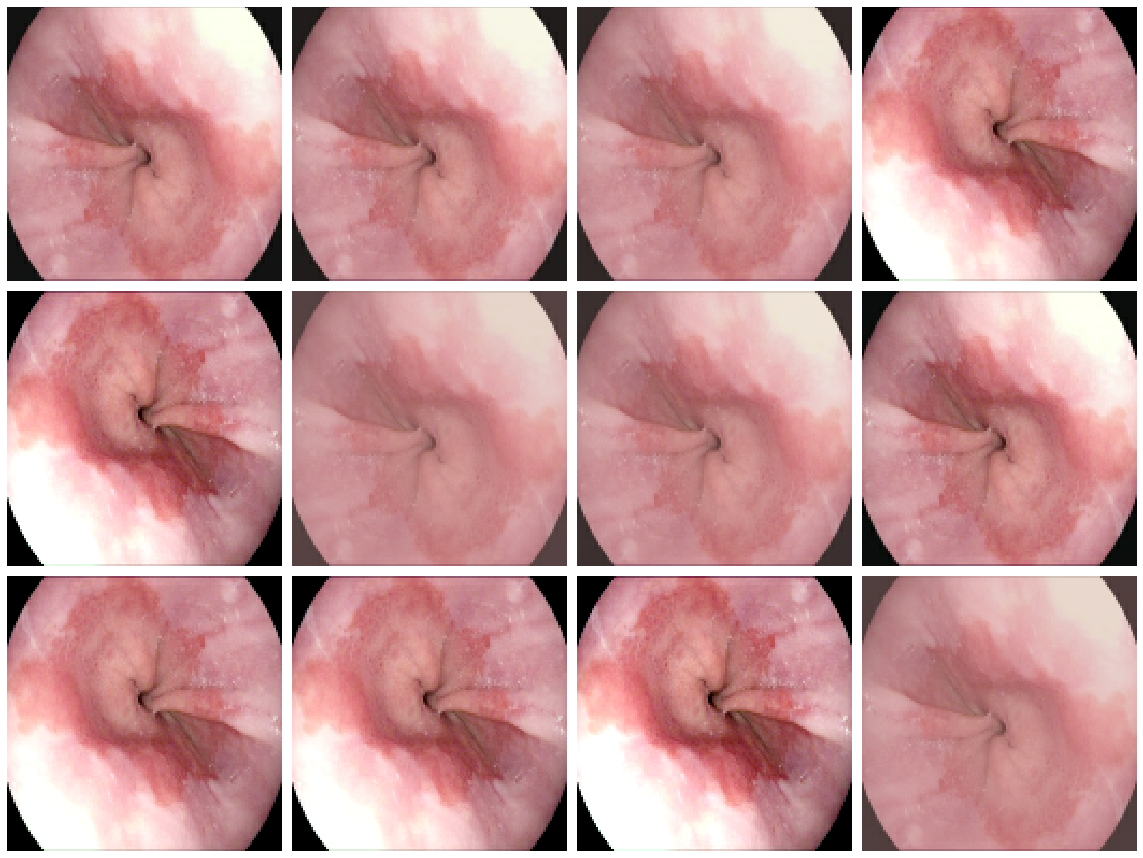

In [128]:
## Test augmentation
from pipeline import augment_ds

conf["augment"] = ["dcrop","flip","rightness","dsaturation","contrast","drotate"]
conf["aug_mult"] = 1   # 0 - no aug | 1.0 full aug

dataset = ds["clean_train"].take(1).cache().repeat(30)
dataset = augment_ds(dataset, conf, tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(30)

checkout_dataset(dataset)